In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
xr.set_options(keep_attrs=True)

In [2]:
mydir = '/glade/work/lettier/CDRv4/mon/'
myvariables = ['cdr_seaice_conc_monthly','nsidc_bt_seaice_conc_monthly','nsidc_nt_seaice_conc_monthly']

In [3]:
nh_area = np.fromfile('/glade/work/lettier/GRIDS/psn25area_v3.dat',dtype='<i4').reshape([448,304])/1000
sh_area = xr.open_dataset('/glade/work/lettier/GRIDS/0_pss25area_netcdf_bt_.nc').areacello.values

In [4]:
sample_ds_nh = xr.open_dataset(mydir+'nhdl/seaice_conc_monthly_nh_198012_n07_v04r00.nc').isel(tdim=0)
sample_ds_sh = xr.open_dataset(mydir+'shdl/seaice_conc_monthly_sh_198012_n07_v04r00.nc').isel(tdim=0)

In [5]:
nhgrid = xr.DataArray(nh_area, dims=['y','x'], coords = {'ygrid':sample_ds_nh.ygrid, 'xgrid':sample_ds_nh.xgrid} ).to_dataset(name='areacello')
nhgrid.areacello.attrs['units'] = 'km^2'
nhgrid.areacello.attrs['long_name'] = 'grid_cell_area'
nhgrid.attrs['description'] = 'grid cell area for NSIDC polar stereographic grid 25km, Northern Hemisphere'

shgrid = xr.DataArray(sh_area,dims=['y','x'],coords= {'ygrid':sample_ds_sh.ygrid, 'xgrid':sample_ds_sh.xgrid}).to_dataset(name='areacello')
shgrid.areacello.attrs['units'] = 'km^2'
shgrid.areacello.attrs['long_name'] = 'grid_cell_area'
shgrid.attrs['description'] = 'grid cell area for NSIDC polar stereographic grid 25km, Southern Hemisphere'

In [6]:
def compute_sia_si_nh (datadir, myfile):

    ds = xr.open_dataset(datadir+myfile)
    ds = ds[myvariables]
    
    flagdict = {}
    for var in myvariables:
        flagdict[var] = False
        if np.count_nonzero(np.isnan(ds[var]))>0.:
            flagdict[var] = True
        
    ds = ds.where(ds<2.5) # keep only valid data
    ints = ds.where(ds>.15) # for ice extent
    ints = ints/ints
    sie = (ints*nhgrid.areacello).sum(dim=('y','x'))/1e6
    sia = (ds*nhgrid.areacello).sum(dim=('y','x'))/1e6
    
    
    
    for var in myvariables: # if any variables has NaNs, set SIE and SIA to NaN
        if flagdict[var]:
            sia[var].values = [np.nan]
            sie[var].values = [np.nan]

    sia = sia.rename({'cdr_seaice_conc_monthly':'sia_nh_cdr','nsidc_bt_seaice_conc_monthly':'sia_nh_bt','nsidc_nt_seaice_conc_monthly':'sia_nh_nt'})
    sie = sie.rename({'cdr_seaice_conc_monthly':'sie_nh_cdr','nsidc_bt_seaice_conc_monthly':'sie_nh_bt','nsidc_nt_seaice_conc_monthly':'sie_nh_nt'})

    sids = xr.merge([sia, sie])
    for var in sids:
        sids[var].attrs['units'] = 'million km^2'
    sids.attrs = ds.attrs
    sids.attrs['processed'] = 'SIA and SIE computed by Lettie Roach, 2021'
    sids = sids.rename({'tdim':'time'})

    
    return sids


def compute_sia_si_sh (datadir, myfile):

    ds = xr.open_dataset(datadir+myfile)
    ds = ds[myvariables]
    
    flagdict = {}
    for var in myvariables:
        flagdict[var] = False
        if np.count_nonzero(np.isnan(ds[var]))>0.:
            flagdict[var] = True
        

    ds = ds.where(ds<2.5) # keep only valid data
    ints = ds.where(ds>.15) # for ice extent
    ints = ints/ints
    sie = (ints*shgrid.areacello).sum(dim=('y','x'))/1e6
    sia = (ds*shgrid.areacello).sum(dim=('y','x'))/1e6
    
    for var in myvariables: # if any variables has NaNs, set SIE and SIA to NaN
        if flagdict[var]:
            sia[var].values = [np.nan]
            sie[var].values = [np.nan]

    sia = sia.rename({'cdr_seaice_conc_monthly':'sia_sh_cdr','nsidc_bt_seaice_conc_monthly':'sia_sh_bt','nsidc_nt_seaice_conc_monthly':'sia_sh_nt'})
    sie = sie.rename({'cdr_seaice_conc_monthly':'sie_sh_cdr','nsidc_bt_seaice_conc_monthly':'sie_sh_bt','nsidc_nt_seaice_conc_monthly':'sie_sh_nt'})

    sids = xr.merge([sia, sie])
    for var in sids:
        sids[var].attrs['units'] = 'million km^2'
    sids.attrs = ds.attrs
    sids.attrs['processed'] = 'SIA and SIE computed by Lettie Roach, 2021'
    sids = sids.rename({'tdim':'time'})

    
    return sids


In [7]:
list_nh = []
for myfile in sorted(os.listdir(mydir+'nhdl/')):
    list_nh.append(compute_sia_si_nh (mydir+'nhdl/', myfile))
sids_nh = xr.concat(list_nh,dim='time')

list_sh = []
for myfile in sorted(os.listdir(mydir+'shdl/')):
    list_sh.append(compute_sia_si_sh (mydir+'shdl/', myfile))
sids_sh = xr.concat(list_sh,dim='time')

outds = xr.merge([sids_nh, sids_sh])
print(outds)

outds.to_netcdf(mydir+'/processed/sia_cdr_monthly_nhsh_197811-202105_v04r00.nc')

<xarray.Dataset>
Dimensions:     (time: 511)
Coordinates:
  * time        (time) datetime64[ns] 1978-11-01 1978-12-01 ... 2021-05-01
Data variables:
    sia_nh_cdr  (time) float64 11.02 12.92 14.54 15.32 ... 13.74 12.83 11.59
    sia_nh_bt   (time) float64 11.35 13.25 14.78 15.51 ... 13.81 12.92 11.7
    sia_nh_nt   (time) float64 10.24 12.08 13.56 14.34 ... 12.99 12.19 10.87
    sie_nh_cdr  (time) float64 12.37 14.28 15.79 16.53 ... 14.64 14.8 13.9 12.89
    sie_nh_bt   (time) float64 12.92 14.9 16.22 16.96 ... 14.87 15.0 14.16 13.17
    sie_nh_nt   (time) float64 12.29 14.28 15.74 16.49 ... 14.5 14.7 13.87 12.8
    sia_sh_cdr  (time) float64 13.14 7.977 3.876 2.363 ... 3.344 6.09 9.162
    sia_sh_bt   (time) float64 13.26 8.113 3.99 2.505 ... 3.432 6.119 9.174
    sia_sh_nt   (time) float64 11.59 7.041 3.534 2.161 ... 2.831 5.274 8.185
    sie_sh_cdr  (time) float64 16.58 11.84 6.051 3.252 ... 5.067 7.844 11.15
    sie_sh_bt   (time) float64 16.82 12.02 6.271 3.52 ... 3.187 5.21 7.89

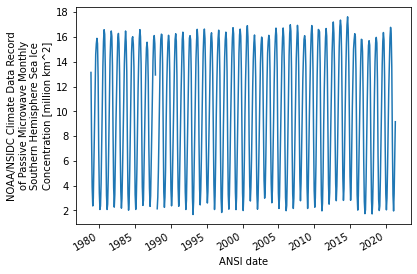

In [8]:
outds.sia_sh_cdr.plot()